In [1]:
import numpy as np
import PIL.Image
import tensorflow as tf

from io import StringIO
from IPython.display import  Image, display, HTML

In [2]:
MODEL_LOC='./InceptionModel/tensorflow_inception_graph.pb'
LABELS_LOC='./InceptionModel/imagenet_comp_graph_label_strings.txt'
def load_model():
  '''Loads the Inception (v1) model and creates a TensorFlow session
     for it.
  '''
  graph = tf.Graph()
  cfg = tf.ConfigProto(gpu_options={'allow_growth':True})
  sess = tf.InteractiveSession(graph=graph, config=cfg)
  graph_def = tf.GraphDef.FromString(open(MODEL_LOC, "rb").read())
  tf.import_graph_def(graph_def)
  return sess, graph

def T(layer):
  '''Helper for getting layer output tensor'''
  return graph.get_tensor_by_name("import/%s:0"%layer)

def run_network(sess, tensor, images):
  '''Helper for evaluating a tensor on a bunch of images
     within a session.
  '''
  imagenet_mean = 117.0
  return sess.run(tensor, {'import/input:0': [img - imagenet_mean for img in images]})

def top_label_and_score(img):
  '''Returns the label and score of the object class
     that receives the highest SOFTMAX score.

     The provided image must of shape (224, 224, 3)
  '''
  # Evaluate the SOFTMAX output layer for the image and
  # determine the label for the highest-scoring class
  t_softmax = tf.reduce_mean(T('softmax2'), reduction_indices=0)
  scores = run_network(sess, t_softmax, [img])
  id = np.argmax(scores)
  return labels[id], scores[id]

def output_label_tensor(label):
  '''Returns a tensor (shape: scalar) representing the SOFTMAX
     for a given label.
  '''
  lab_index = np.where(np.in1d(labels, [label]))[0][0]
  t_softmax = tf.reduce_sum(T('softmax2'), reduction_indices=0)
  return t_softmax[lab_index]

def gradients(img, label):
  '''Returns attributions for the prediction label based
     on just the gradients at the image.

     Specifically, the method returns the dot product of the image
     and the gradients of the provided prediction label (w.r.t. the
     image).

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  grads = run_network(sess, t_grad, [img])
  return img*grads[0]

def integrated_gradients(img, label, steps=50):
  '''Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided image.

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  scaled_images = [(float(i)/steps)*img for i in range(1, steps+1)]
  # Compute the gradients of the scaled images
  grads = run_network(sess, t_grad, scaled_images)
  return img*np.average(grads, axis=0),grads

def integrated_gradients2(img, label, steps=50):
  '''Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided image.

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  scaled_images = [img for i in range(1, steps+1)]
  # Compute the gradients of the scaled images
  grads = run_network(sess, t_grad, scaled_images)
  return img*np.average(grads, axis=0),grads

def integrated_gradients3(img, label, steps=50):
  '''Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided image.

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  scaled_images = [img]
  # Compute the gradients of the scaled images
  grads = run_network(sess, t_grad, scaled_images)
  return img*np.average(grads, axis=0),grads

def pil_img(a):
  '''Returns a PIL image created from the provided RGB array.
  '''
  a = np.uint8(a)
  return PIL.Image.fromarray(a)

def show_img(img, fmt='jpeg'):
  '''Displays the provided PIL image
  '''
  #f = StringIO()
  #img.save(f, fmt)
  #display(Image(data=f.getvalue()))
  display(img)

def gray_scale(img):
  '''Converts the provided RGB image to gray scale.
  '''
  img = np.average(img, axis=2)
  return np.transpose([img, img, img], axes=[1,2,0])

def normalize(attrs, ptile=99):
  '''Normalize the provided attributions so that they fall between
     -1.0 and 1.0.
  '''
  h = np.percentile(attrs, ptile)
  l = np.percentile(attrs, 100-ptile)
  return np.clip(attrs/max(abs(h), abs(l)), -1.0, 1.0)    
      
def visualize_attrs_windowing(img, attrs, ptile=99):
   '''Visaualizes the provided attributions by first aggregating them
      along the color channel to obtain per-pixel attributions and then
      scaling the intensities of the pixels in the original image in
      proportion to absolute value of these attributions.

      The provided image and attributions must of shape (224, 224, 3).
   '''
   attrs = gray_scale(attrs)
   attrs = abs(attrs)
   attrs = np.clip(attrs/np.percentile(attrs, ptile), 0,1)
   vis = img*attrs
   show_img(pil_img(vis))
  
R=np.array([255,0,0])
G=np.array([0,255,0])
B=np.array([0,0,255])
def visualize_attrs_overlay(img, attrs, pos_ch=G, neg_ch=R, ptile=99):
  '''Visaualizes the provided attributions by first aggregating them
     along the color channel and then overlaying the positive attributions
     along pos_ch, and negative attributions along neg_ch.

     The provided image and attributions must of shape (224, 224, 3).
  '''
  attrs = gray_scale(attrs)
  attrs = normalize(attrs, ptile)   
  pos_attrs = attrs * (attrs >= 0.0)
  neg_attrs = -1.0 * attrs * (attrs < 0.0)
  attrs_mask = pos_attrs*pos_ch + neg_attrs*neg_ch
  vis = 0.3*gray_scale(img) + 0.7*attrs_mask
  show_img(pil_img(vis))


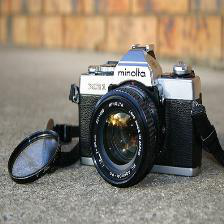

In [12]:
# Load the Inception model.
sess, graph = load_model()

# Load the labels vocabulary.
labels = np.array(open(LABELS_LOC).read().split('\n'))

# Load the image.
with open('./Images/8e570672510267d3.jpg', 'rb') as f:
  img = f.read()
  img = sess.run(tf.image.decode_jpeg(img))
show_img(pil_img(img))

Top label: reflex camera, score: 0.998974
Gradients at the Image


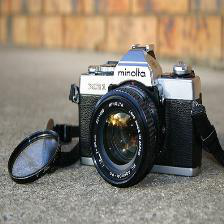

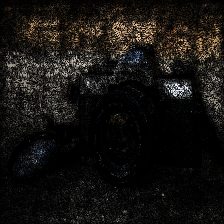

Gradients at the Image with scalar:0.02 avg:6.152672672876093e-05


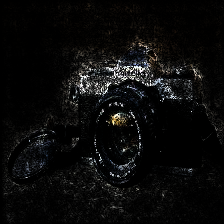

Gradients at the Image with scalar:0.04 avg:8.95854315945248e-05


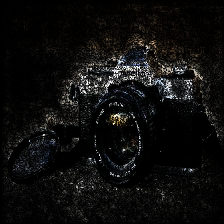

Gradients at the Image with scalar:0.06 avg:6.5438912070739054e-06


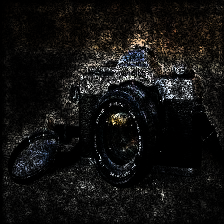

Gradients at the Image with scalar:0.08 avg:1.617542887216967e-06


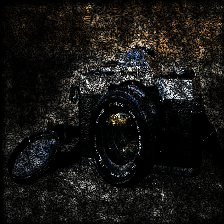

Gradients at the Image with scalar:0.1 avg:4.024356940302675e-07


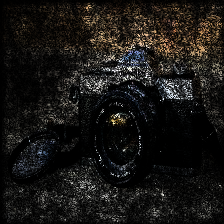

Gradients at the Image with scalar:0.12 avg:1.8298526598318563e-07


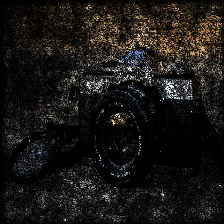

Gradients at the Image with scalar:0.14 avg:1.1996528789148662e-07


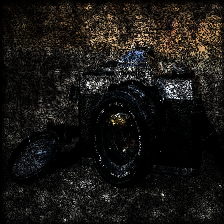

Gradients at the Image with scalar:0.16 avg:5.2506274131060946e-08


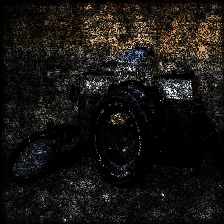

Gradients at the Image with scalar:0.18 avg:3.1697709648822546e-11


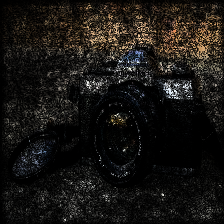

Gradients at the Image with scalar:0.2 avg:8.074789565462197e-08


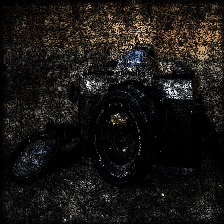

Gradients at the Image with scalar:0.22 avg:1.2883722346065407e-07


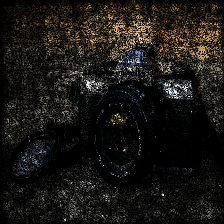

Gradients at the Image with scalar:0.24 avg:1.0691764981383312e-07


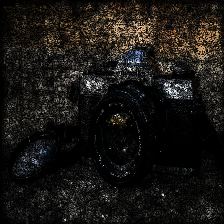

Gradients at the Image with scalar:0.26 avg:8.761267872870431e-08


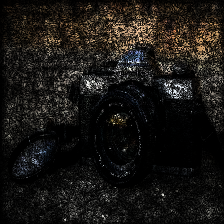

Gradients at the Image with scalar:0.28 avg:7.433978982877768e-08


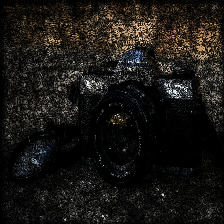

Gradients at the Image with scalar:0.3 avg:3.87637195931492e-08


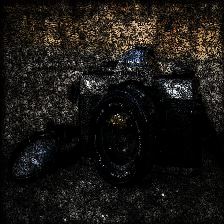

Gradients at the Image with scalar:0.32 avg:3.609046618866015e-08


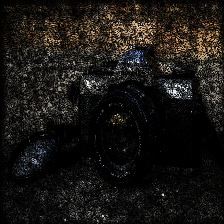

Gradients at the Image with scalar:0.34 avg:3.804343167915995e-08


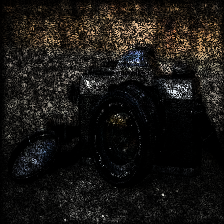

Gradients at the Image with scalar:0.36 avg:3.3492245762947565e-08


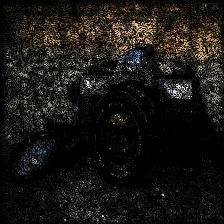

Gradients at the Image with scalar:0.38 avg:3.8676187783471746e-08


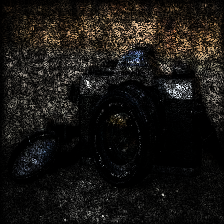

Gradients at the Image with scalar:0.4 avg:3.0431164643297246e-08


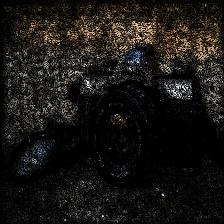

Gradients at the Image with scalar:0.42 avg:2.3676451386746153e-08


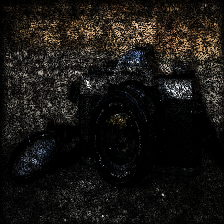

Gradients at the Image with scalar:0.44 avg:1.983517510547888e-08


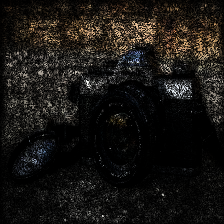

Gradients at the Image with scalar:0.46 avg:2.1131144402072553e-08


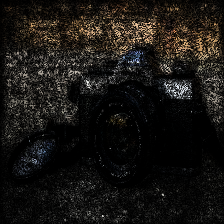

Gradients at the Image with scalar:0.48 avg:2.000595739792956e-08


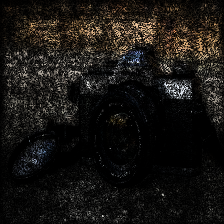

Gradients at the Image with scalar:0.5 avg:1.572634713122702e-08


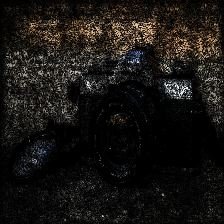

Gradients at the Image with scalar:0.52 avg:1.0532548728208413e-08


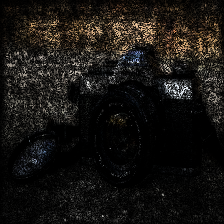

Gradients at the Image with scalar:0.54 avg:7.262948173473951e-09


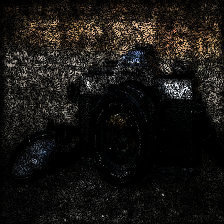

Gradients at the Image with scalar:0.56 avg:9.9455246270816e-09


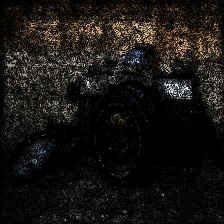

Gradients at the Image with scalar:0.58 avg:8.611823708996854e-09


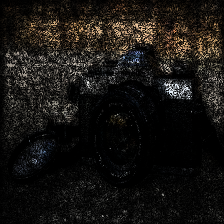

Gradients at the Image with scalar:0.6 avg:6.409166921620765e-09


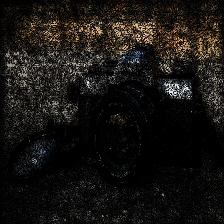

Gradients at the Image with scalar:0.62 avg:1.735275889451167e-08


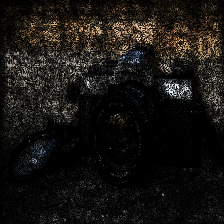

Gradients at the Image with scalar:0.64 avg:2.509553619381736e-08


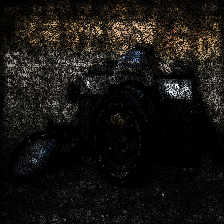

Gradients at the Image with scalar:0.66 avg:2.791624869023711e-08


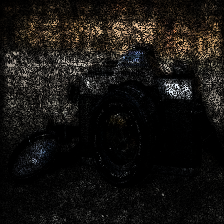

Gradients at the Image with scalar:0.68 avg:2.719176923479285e-08


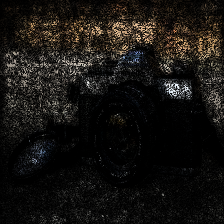

Gradients at the Image with scalar:0.7 avg:2.6565141866000485e-08


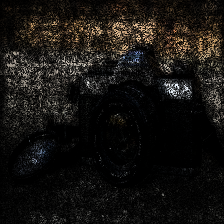

Gradients at the Image with scalar:0.72 avg:1.987074351312932e-08


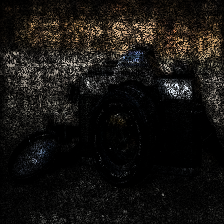

Gradients at the Image with scalar:0.74 avg:1.4598959720626391e-08


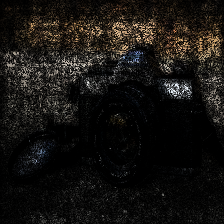

Gradients at the Image with scalar:0.76 avg:1.9553324639515567e-08


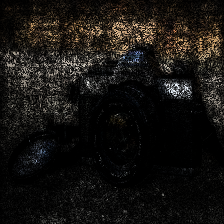

Gradients at the Image with scalar:0.78 avg:1.2491781179418474e-08


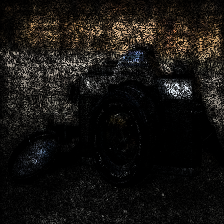

Gradients at the Image with scalar:0.8 avg:1.662304242526782e-08


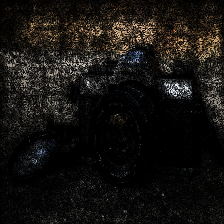

Gradients at the Image with scalar:0.82 avg:1.0464611156523903e-08


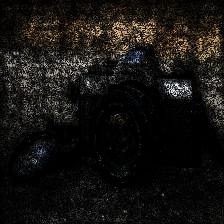

Gradients at the Image with scalar:0.84 avg:1.0046563648672722e-08


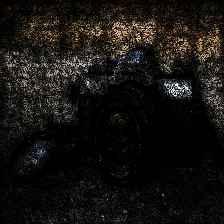

Gradients at the Image with scalar:0.86 avg:2.7927571690580297e-09


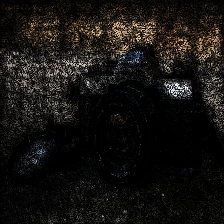

Gradients at the Image with scalar:0.88 avg:2.090515614636903e-09


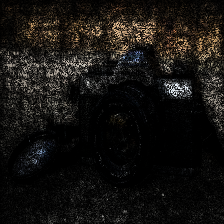

Gradients at the Image with scalar:0.9 avg:3.886775874035634e-09


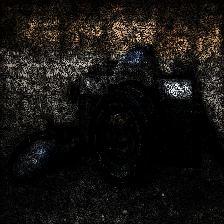

Gradients at the Image with scalar:0.92 avg:7.675574547037374e-09


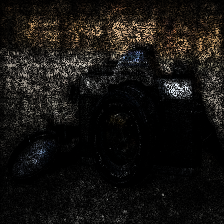

Gradients at the Image with scalar:0.94 avg:7.18464159995792e-09


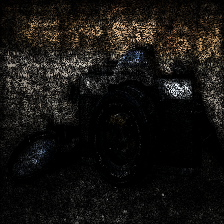

Gradients at the Image with scalar:0.96 avg:6.060931587094595e-09


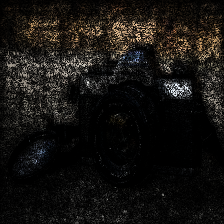

Gradients at the Image with scalar:0.98 avg:6.214659146513056e-09


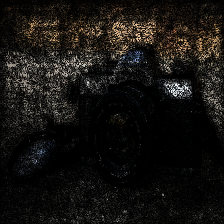

Gradients at the Image with scalar:1.0 avg:7.2489672483053025e-09


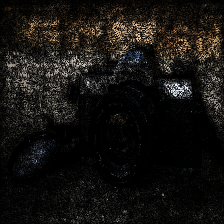

In [13]:
# Determine top label and score.
top_label, score = top_label_and_score(img)
print("Top label: %s, score: %f" % (top_label, score))

# Compute attributions based on just the gradients.
grads_attrs = gradients(img, top_label)
print("Gradients at the Image")
show_img(pil_img(img))
visualize_attrs_windowing(img, grads_attrs)
gradient = []
steps = 50
for i in range(1,steps+1):
    gra = gradients((float(i)/steps)*img, top_label)
    gradient.append(gra*(steps/float(i)))
    print("Gradients at the Image with scalar:{} avg:{}".format(i/steps, np.average(gradient[i-1])))
    visualize_attrs_windowing(img, gradient[i-1])
gradient_avg=np.average(gradient,axis=0)    

Gradients at the Image with scalar:0.02 shape:(224, 224, 3) avg:6.152672672876093e-05
Gradients at the Image with scalar:0.04 shape:(224, 224, 3) avg:8.95854315945248e-05
Gradients at the Image with scalar:0.06 shape:(224, 224, 3) avg:6.5438912070739054e-06
Gradients at the Image with scalar:0.08 shape:(224, 224, 3) avg:1.617542887216967e-06
Gradients at the Image with scalar:0.1 shape:(224, 224, 3) avg:4.024356940302675e-07
Gradients at the Image with scalar:0.12 shape:(224, 224, 3) avg:1.8298526598318563e-07
Gradients at the Image with scalar:0.14 shape:(224, 224, 3) avg:1.1996528789148662e-07
Gradients at the Image with scalar:0.16 shape:(224, 224, 3) avg:5.2506274131060946e-08
Gradients at the Image with scalar:0.18 shape:(224, 224, 3) avg:3.1697709648822546e-11
Gradients at the Image with scalar:0.2 shape:(224, 224, 3) avg:8.074789565462197e-08
Gradients at the Image with scalar:0.22 shape:(224, 224, 3) avg:1.2883722346065407e-07
Gradients at the Image with scalar:0.24 shape:(224,

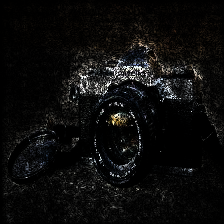

Integrated gradients


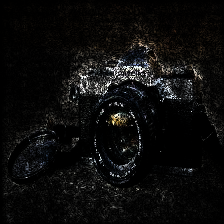

Gradients at the Image with scalar:0.02 shape:(224, 224, 3) avg:6.152669084258378e-05
Gradients at the Image with scalar:0.04 shape:(224, 224, 3) avg:8.958522084867582e-05
Gradients at the Image with scalar:0.06 shape:(224, 224, 3) avg:6.543933523062151e-06
Gradients at the Image with scalar:0.08 shape:(224, 224, 3) avg:1.6175441714949557e-06
Gradients at the Image with scalar:0.1 shape:(224, 224, 3) avg:4.0243466514766624e-07
Gradients at the Image with scalar:0.12 shape:(224, 224, 3) avg:1.8298609916200803e-07
Gradients at the Image with scalar:0.14 shape:(224, 224, 3) avg:1.199667138962468e-07
Gradients at the Image with scalar:0.16 shape:(224, 224, 3) avg:5.2507115100297597e-08
Gradients at the Image with scalar:0.18 shape:(224, 224, 3) avg:2.973800025674045e-11
Gradients at the Image with scalar:0.2 shape:(224, 224, 3) avg:8.074837154481429e-08
Gradients at the Image with scalar:0.22 shape:(224, 224, 3) avg:1.288373283614419e-07
Gradients at the Image with scalar:0.24 shape:(224, 

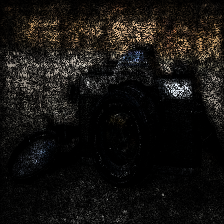

Gradients at the Image with scalar:0.02 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.04 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.06 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.08 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.1 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.12 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.14 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.16 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.18 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.2 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.22 shape:(224, 224, 3) avg:7.248960542938221e-09
Gradients at the Image with scalar:0.24 shape:(224, 224,

In [14]:
for i in range(steps):
    print("Gradients at the Image with scalar:{} shape:{} avg:{}".format((i+1)/steps, gradient[i].shape, np.average(gradient[i])))
    
    
    
    
visualize_attrs_windowing(img, gradient_avg)

# Compute attributions based on the integrated gradients
# method.
intgrads_attrs,grads = integrated_gradients(img, top_label,steps)
print("Integrated gradients")
visualize_attrs_windowing(img, intgrads_attrs)
for i in range(steps):
    print("Gradients at the Image with scalar:{} shape:{} avg:{}".format((i+1)/steps, (img*grads[i]).shape, np.average(img*grads[i])))
    
intgrads_attrs,grads = integrated_gradients2(img, top_label,steps)
print("Integrated gradients")
visualize_attrs_windowing(img, intgrads_attrs)
for i in range(steps):
    print("Gradients at the Image with scalar:{} shape:{} avg:{}".format((i+1)/steps, (img*grads[i]).shape, np.average(img*grads[i])))
    
       
intgrads_attrs,grads = integrated_gradients3(img, top_label,steps)
print("Gradients at the Image with scalar:{} shape:{} avg:{}".format((i+1)/steps, (img*grads[0]).shape, np.average(img*grads[0])))
    

In [9]:
averages=[]
for i in range(steps):
    averages.append(np.average(gradient[i]))
    


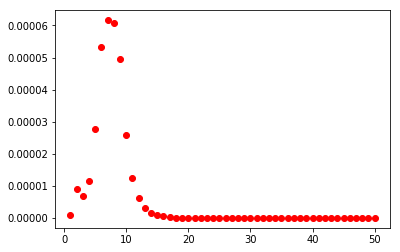

In [11]:

import matplotlib.pyplot as plt
plt.plot(list(range(1,steps+1)), averages, 'ro')
plt.show()

In [129]:
gra = gradients((float(3)/3)*img, top_label)
print("Gradients at the Image with scalar:{} avg:{}".format(i/steps, np.average(gra*3)))
gra = gradients(img, top_label)
print("Gradients at the Image with scalar:{} avg:{}".format(i/steps, np.average(gra)))

Gradients at the Image with scalar:1.0 avg:2.389262636431167e-10
Gradients at the Image with scalar:1.0 avg:7.964268827764798e-11


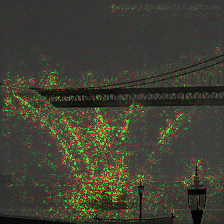

In [5]:
# Exploring overlay visualization
visualize_attrs_overlay(img, intgrads_attrs)

Integrated gradients


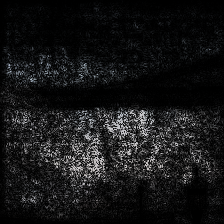

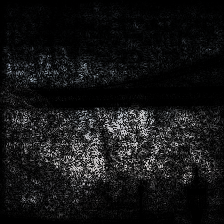

In [41]:

intgrads_attrs,grads = integrated_gradients(img, top_label,steps=1)
print("Integrated gradients")
visualize_attrs_windowing(img, np.average(grads,axis=0))
visualize_attrs_windowing(img, intgrads_attrs)

Gradients at the Image with scalar:0.5 avg:1.802062503916235e-09
Gradients at the Image with scalar:1.0 avg:7.96420878810389e-11


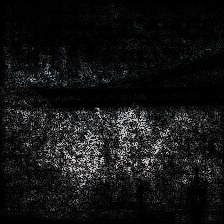

In [84]:
gradient = []
for i in range(1,3):
    gra = gradients(img*float(i/2), top_label)
    gradient.append(gra)
    print("Gradients at the Image with scalar:{} avg:{}".format(i/2, np.average(gradient[i-1])))
gradient_avg=np.average(gradient,axis=0) 
visualize_attrs_windowing(img, gradient_avg)